In [1]:
import os, sys
import torch as th
import numpy as np
import matplotlib.pyplot as plt

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans/scripts/')
import preProcess as pre

In [2]:
path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/pitzDaily/kEpsilon'
rans_time = '282'

In [3]:
# funtion for distoring fields
def distortion(b, x):
    factor  = -(x - th.min(x))* (x - th.max(x))
    b_ = b*(1 - 200*factor)
    return b_

In [4]:
rs = pre.readSymTensorData(rans_time, 'turbulenceProperties:R', path).reshape(-1,3,3)
cellCenters = pre.readCellCenters(rans_time, path)

# compute k
k0 = 0.5*th.from_numpy(rs.numpy().trace(axis1 = 1, axis2 = 2))
k = k0.unsqueeze(0).unsqueeze(0).expand(3, 3, k0.shape[0])
k = k.permute(2, 0, 1)

# compute b
b0 = rs/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)

# initialize new b
b_dd = th.zeros_like(b0)

# filling off diagonal entries
for i in range(3):
    for j in range(3):
        if i != j:
            b_dd[:,i,j] = b0[:,i,j]
        else:
            b_dd[:,i,i] = distortion(b0[:,i,i], cellCenters[:,0])

Attempting to read file: /home/leonriccius/OpenFOAM/leonriccius-v2006/run/pitzDaily/kEpsilon/282/turbulenceProperties:R
Parsing file...
Data field file successfully read.
Reading mesh cell centers /home/leonriccius/OpenFOAM/leonriccius-v2006/run/pitzDaily/kEpsilon/282/cellCenters


In [5]:
# filename = "/home/leonriccius/Desktop/b_dd_raw"

# outfile = open(filename, 'w')

# for i in range(b_dd.shape[0]):
#     outfile.write("({:9f} {:9f} {:9f} {:9f} {:9f} {:9f})\n".format(b_dd[i,0,0], b_dd[i,0,1],
#                                                                    b_dd[i,0,2], b_dd[i,1,1],
#                                                                    b_dd[i,1,2], b_dd[i,2,2]))

# outfile.close()

In [6]:
filename = "/home/leonriccius/Desktop/foam_header"
f = open(filename, 'r')
if f.mode=='r':
    header = f.read()
f.close()

In [7]:
header

'/*--------------------------------*- C++ -*----------------------------------*\\\n| =========                 |                                                 |\n| \\\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |\n|  \\\\    /   O peration     | Version:  v2006                                 |\n|   \\\\  /    A nd           | Website:  www.openfoam.com                      |\n|    \\\\/     M anipulation  |                                                 |\n\\*---------------------------------------------------------------------------*/\nFoamFile\n{\n    version     2.0;\n    format      ascii;\n    class       volSymmTensorField;\n    location    "0";\n    object      b_dd;\n}\n// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n\ndimensions      [0 0 0 0 0 0 0];\n\n\ninternalField   nonuniform List<symmTensor>\n'

In [50]:
# dict for boundary types
b_type = {'empty': "        {0:<16}{1}\n".format("type", "empty;"),
          'fixedValue': "        {0:<16}{1}\n".format("type", "fixedValue;")+
                        "        {0:<16}{1}\n".format("value", "uniform (0 0 0 0 0 0);"),
          'zeroGradient': "        {0:<16}{1}\n".format("type", "zeroGradient;")}

# list for boundary names and corrresponding type
boundaries = [('inlet','fixedValue'),
              ('outlet','zeroGradient'),
              ('upperWall', 'fixedValue'),
              ('lowerWall', 'fixedValue'),
              ('frontAndBack', 'empty')]

In [57]:
filename = "/home/leonriccius/Desktop/b_dd"

# open file
outfile = open(filename, 'w')

# write foam header
outfile.write(header)

# write number of internal points
outfile.write("{}\n(\n".format(b0.shape[0]))

# write internal points
for i in range(b0.shape[0]):
    outfile.write("({:9f} {:9f} {:9f} {:9f} {:9f} {:9f})\n".format(b_dd[i,0,0], b_dd[i,0,1],
                                                                   b_dd[i,0,2], b_dd[i,1,1],
                                                                   b_dd[i,1,2], b_dd[i,2,2]))

# write boundary patches
outfile.write(")\n;\n\nboundaryField\n{\n")

# loop over boundaries list
for boundary in boundaries:
    outfile.write("    {}\n".format(boundary[0]))
    outfile.write("    {\n")
    outfile.write(b_type[format(boundary[1])])
    outfile.write("    }\n")

outfile.write("}")

# write closing lines of foam 
outfile.write("\n\n\n// ************************************************************************* //")

# close file
outfile.close()

In [10]:
factor_test = -50*(cellCenters[:,0] - th.min(cellCenters[:,0]))* (cellCenters[:,0] - th.max(cellCenters[:,0]))

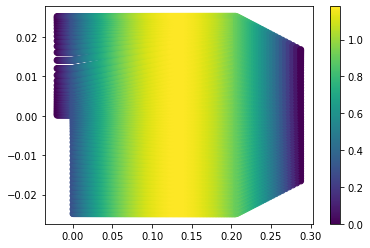

In [11]:
fig, ax = plt.subplots()
test = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=factor_test)
fig.colorbar(test)

In [12]:
b_dd[:,0,0] = distortion(b0[:,0,0], cellCenters[:,0])
th.min(b_dd[:,0,0] - b0[:,0,0])

tensor(-0.3107, dtype=torch.float64)

In [13]:
th.min((b_dd - b0)[:,0,0])

tensor(-0.3107, dtype=torch.float64)

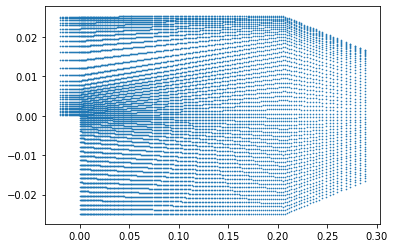

In [14]:
fig, ax = plt.subplots()
_ =ax.scatter(cellCenters[:,0].numpy(), cellCenters[:,1].numpy(), s=0.4)

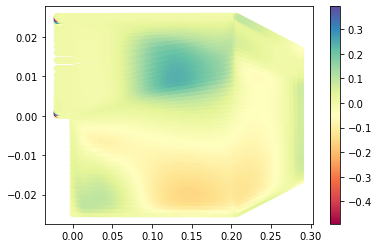

In [15]:
fig, ax = plt.subplots()
diff_dd = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_dd[:,1,1], cmap="Spectral")
fig.colorbar(diff_dd)

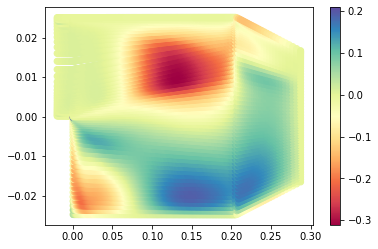

In [16]:
fig, ax = plt.subplots()
diff = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=(b_dd[:,0,0]-b0[:,0,0]), cmap="Spectral")
plt.colorbar(diff)

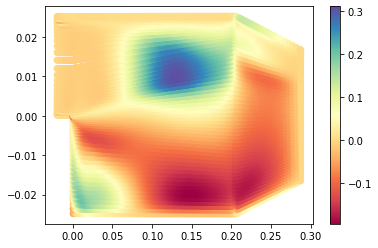

In [17]:
fig, ax = plt.subplots()
diff_2 = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=(b_dd[:,1,1]-b0[:,1,1]), cmap="Spectral")
plt.colorbar(diff_2)

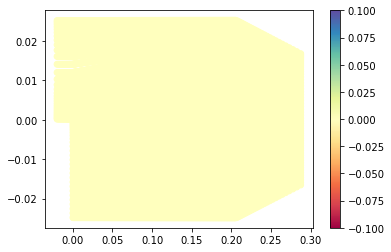

In [18]:
fig, ax = plt.subplots()
diff_3 = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=(b_dd[:,1,2]-b0[:,1,2]), cmap="Spectral")
plt.colorbar(diff_3)

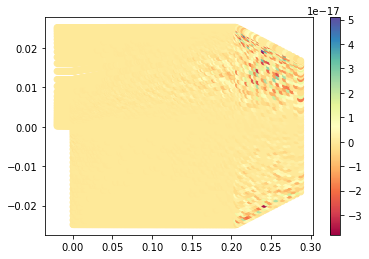

In [19]:
fig, ax = plt.subplots()
off_diag = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=(b_dd[:,1,2]), cmap="Spectral")
plt.colorbar(off_diag)